In [1]:
import pickle
import json
from collections import defaultdict as ddict 
from collections import Counter as Cntr
import os.path as osp
import numpy.random as npr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
root = Path("./rawdataXcode")

## Fisrt way

Load all data and extract the submatrix from the whole mat

#### Num of reviews for each restaurant

In [7]:
RestDic = ddict(set)
RestCnt = Cntr()

if not osp.isfile(root/"RestDicCnt.pkl"):
    for idx, oneobs in enumerate(open(root/"review.json", "r")):
        print(f"Current index is {idx}")
        oneobs = json.loads(oneobs)
        RestDic[oneobs["business_id"]].add(oneobs["user_id"])
        RestCnt[oneobs["business_id"]]  += 1
        if idx == 1000:
            pass#break
    
    with open(root/"RestDicCnt.pkl", "wb") as f:
        pickle.dump([RestDic, RestCnt], f)

with open(root/"RestDicCnt.pkl", "rb") as f:
    RestDicCnt = pickle.load(f)

RestDic = RestDicCnt[0]
RestCnt = RestDicCnt[1]

#### Num of reviews for each users

In [8]:
UserDic = ddict(set)
UserCnt = Cntr()

if not osp.isfile(root/"UserDicCnt.pkl"):
    for idx, oneobs in enumerate(open(root/"review.json", "r")):
        oneobs = json.loads(oneobs)
        UserDic[oneobs["user_id"]].add(oneobs["business_id"])
        UserCnt[oneobs["user_id"]]  += 1

    with open(root/"UserDicCnt.pkl", "wb") as f:
        pickle.dump([UserDic, UserCnt], f)

with open(root/"UserDicCnt.pkl", "rb") as f:
    UserDicCnt = pickle.load(f)

UserDic = UserDicCnt[0]
UserCnt = UserDicCnt[1]

#### Sort the count w.r.t the number of reviewers and choose restaurants

In [9]:
m = 1000
n = 1000
sortRCnt = RestCnt.most_common()
allRests = [i[0] for i in sortRCnt]
selRests = allRests[:m]

In [10]:
selUserCnt = Cntr()
for user, rests in UserDic.items():
    selUserCnt[user] = len(rests.intersection(selRests))

In [11]:
selUsers = [i[0] for i in selUserCnt.most_common()[:n]]

In [12]:
# funtion ot extract the Y mat
def size2mat():
    subRests = selRests
    subUsers = selUsers
    n, m = len(subUsers), len(subRests)
    mat = np.zeros((n, m))
    
    for idxn, user in enumerate(subUsers):
        cRests = UserDic[user]
        for idxm, rest in enumerate(subRests):
            if rest in cRests:
                mat[idxn, idxm] = 1
    return mat

In [13]:
np.mean(size2mat())

0.058635

## Second way

Select a mat by city

In [14]:
with open(root/"./CityRest.pkl", "rb") as f:
    city = pickle.load(f)

In [15]:
cityCnt = Cntr()

for key, v in city.items():
    cityCnt[key] = len(v)
    
sortedCityCnt = cityCnt.most_common()
sortedCity = [i[0] for i in sortedCityCnt]

In [16]:
cCity =sortedCity[0]
cCityRests = city[cCity]

In [17]:
ccRestCnt = Cntr()
ccUserDic = ddict(set)
ccUserCnt = Cntr()
for ccRest in cCityRests:
    ccRestCnt[ccRest] = RestCnt[ccRest]
    ccUsers = RestDic[ccRest]
    for ccUser in ccUsers:
        ccUserDic[ccUser].add(ccRest)
        ccUserCnt[ccUser] += 1
    
sortRCnt = ccRestCnt.most_common()
ccRests = [i[0] for i in sortRCnt]
sortUCnt = ccUserCnt.most_common()
ccUsers = [i[0] for i in sortUCnt]

In [18]:
m = 500
n = 1000

cSelRests = ccRests[:m]

In [19]:
cSelUserCnt = Cntr()
for user, rests in ccUserDic.items():
    cSelUserCnt[user] = len(rests.intersection(cSelRests))

In [20]:
cSelUsers = [i[0] for i in cSelUserCnt.most_common()[:n]]

In [21]:
# funtion to extract the Y mat
def citysize2mat():
    subRests = cSelRests
    subUsers = cSelUsers
    n, m = len(subUsers), len(subRests)
    mat = np.zeros((n, m))
    
    for idxn, user in enumerate(subUsers):
        cRests = UserDic[user]
        for idxm, rest in enumerate(subRests):
            if rest in cRests:
                mat[idxn, idxm] = 1
    return mat

In [22]:

mat = citysize2mat()
np.mean(mat)

0.09109

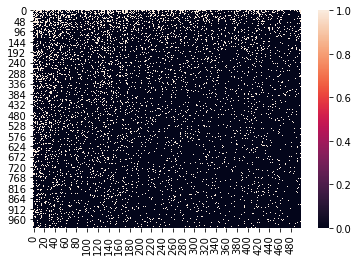

In [23]:
sns.heatmap(mat)

### The selected resturant and users are 

`cSelRests` and `cSelUsers`

### To data 

In [39]:
saveRoot = Path("./JMLR-R1")

In [40]:
if not osp.isfile(saveRoot/"Y.pkl"):
    Y = ddict(dict)
    for idx, oneobs in enumerate(open(root/"review.json", "r")):
        oneobs = json.loads(oneobs)
        crest = oneobs["business_id"]
        ccust = oneobs["user_id"] 
        if (crest in cSelRests) and (ccust in cSelUsers):
            Y[crest][ccust] = {"stars":oneobs["stars"], "date": oneobs["date"], "UFC":[oneobs["useful"], oneobs["funny"], oneobs["cool"]]}
        if idx == 1000:
            pass #break
    
    with open(saveRoot/"Y.pkl", "wb") as f:
        pickle.dump(Y, f)

with open(saveRoot/"Y.pkl", "rb") as f:
    Y = pickle.load(f)

In [41]:
if not osp.isfile(saveRoot/"Xrest.pkl"):
    Xrest = {}
    for idx1, oneobs in enumerate(open(root/"business.json", "r")):
        oneobs = json.loads(oneobs)
        crest = oneobs["business_id"]
        if crest in cSelRests:
            Xrest[crest] = oneobs
    with open(saveRoot/"Xrest.pkl", "wb") as f:
        pickle.dump(Xrest, f)

with open(saveRoot/"Xrest.pkl", "rb") as f:
    Xrest = pickle.load(f)

In [42]:
if not osp.isfile(saveRoot/"Xuser.pkl"):
    Xuser = {}
    for idx2, userobs in enumerate(open(root/"user.json", "r")):
        userobs = json.loads(userobs)
        ccust = userobs["user_id"]
        if ccust in cSelUsers:
            Xuser[ccust] = userobs
    with open(saveRoot/"Xuser.pkl", "wb") as f:
        pickle.dump(Xuser, f)

with open(saveRoot/"Xuser.pkl", "rb") as f:
    Xuser = pickle.load( f)

 - columns: restuarants, m 
 
 - rows: customers, n
 
 - covariates:
   - Reviews: [weekend, Ruseful, Rfunny, Rcool] removed
   - users: [review_count, yelping_since, num_of_friends, Uuseful, Ufunny, Ucool, fans, num_of_elite, av_stars, c_hot, c_more, c_p, c_cute, c_list, c_note, c_plain, c_cool,  c_funny, c_writer, c_photos]
   - bussiness: [stars, review_count, is_open, RestTakeOut, BPgarage, BPstreet, BPvalidated, BPlot, BPvalet, hrs_weekdays, hrs_weekend] 


In [43]:
from datetime import datetime
import ast

def date2weekday(datestring):
    date = datetime.strptime(datestring, "%Y-%m-%d")
    weekday = date.weekday()
    if weekday >= 5:
        return 1
    else:
        return 0

def hours2num(hours):
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    weekends = ["Sunday", "Saturday"]
    def int2del(intstring):
        begint, endt  = intstring.split("-")[0], intstring.split("-")[1]
        beginth, begintm = begint.split(":")
        endth, endtm = endt.split(":")
        hrs = float(endth)-float(beginth) + (float(endtm) - float(begintm))/60
        if hrs == 0:
            return 24
        else:
            return hrs
    weekdayhours = np.sum([int2del(hours[weekday]) for weekday in weekdays if weekday in hours.keys()])
    weekendhours = np.sum([int2del(hours[weekend]) for weekend in weekends if weekend in hours.keys()])
    return weekdayhours, weekendhours

# sort the users and restaurants
cSelUsers = sorted(cSelUsers)
cSelRests = sorted(cSelRests)

if not osp.isfile(saveRoot/"Ymat.pkl"):
    Ymat = np.zeros((n, m)) - 1
    for idxcol, restaurant in enumerate(cSelRests):
        datarest = Y[restaurant]
        userkeys = datarest.keys()
        for idxrow, customer in enumerate(cSelUsers):
            if customer in userkeys:
                Ymat[idxrow, idxcol] = datarest[customer]["stars"]
    with open(saveRoot/"Ymat.pkl", "wb") as f:
        pickle.dump(Ymat, f)
with open(saveRoot/"Ymat.pkl", "rb") as f:
    Ymat = pickle.load(f)




In [44]:
p = 22
if not osp.isfile(saveRoot/"Xmat.pkl"):
    Xmat = np.zeros((n, m, p)) - 1
    for idxcol, restaurant in enumerate(cSelRests):
        cRestDat = Xrest[restaurant]
        for idxrow, customer in enumerate(cSelUsers):
            cCustDat = Xuser[customer]
            Xmat[idxrow, idxcol, 0] = cCustDat["review_count"]
            Xmat[idxrow, idxcol, 1] = len(cCustDat["friends"])
            Xmat[idxrow, idxcol, 2] = cCustDat["useful"]
            Xmat[idxrow, idxcol, 3] = cCustDat["funny"]
            Xmat[idxrow, idxcol, 4] = cCustDat["cool"]
            Xmat[idxrow, idxcol, 5] = cCustDat["fans"]
            Xmat[idxrow, idxcol, 6] = len(cCustDat["elite"])
            Xmat[idxrow, idxcol, 7] = cCustDat["average_stars"]
            Xmat[idxrow, idxcol, 8] = cCustDat["compliment_hot"]
            Xmat[idxrow, idxcol, 9] = cCustDat["compliment_more"]
            Xmat[idxrow, idxcol, 10] = cCustDat["compliment_profile"]
            Xmat[idxrow, idxcol, 11] = cCustDat["compliment_cute"]
            Xmat[idxrow, idxcol, 12] = cCustDat["compliment_list"]
            Xmat[idxrow, idxcol, 13] = cCustDat["compliment_note"]
            Xmat[idxrow, idxcol, 14] = cCustDat["compliment_plain"]
            Xmat[idxrow, idxcol, 15] = cCustDat["compliment_cool"]
            Xmat[idxrow, idxcol, 16] = cCustDat["compliment_funny"]
            Xmat[idxrow, idxcol, 17] = cCustDat["compliment_writer"]
            Xmat[idxrow, idxcol, 18] = cCustDat["compliment_photos"]
            Xmat[idxrow, idxcol, 19] = cRestDat["stars"]
            Xmat[idxrow, idxcol, 20] = cRestDat["review_count"]
            Xmat[idxrow, idxcol, 21] = cRestDat["is_open"]
    with open(saveRoot/"Xmat.pkl", "wb") as f:
        pickle.dump(Xmat, f)

with open(saveRoot/"Xmat.pkl", "rb") as f:
    Xmat = pickle.load(f)